# Plot Graph Measures

Here we plot different **graph measures** from the computed connectivity matrices.

In [38]:
from pprint import pprint

In [39]:
import scipy

In [40]:
import pandas as pd

In [41]:
from pandas.tools.plotting import parallel_coordinates

In [42]:
from pandas import concat

In [43]:
import matplotlib
# Set backend to pgf
matplotlib.use('pgf')
import matplotlib.pyplot as plt
import numpy as np

# Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.color_cycle'] = ['g', 'b', 'r']
plt.gray()

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1155: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [44]:
%matplotlib inline

In [48]:
from pylab import *

In [45]:
from scipy.io import loadmat

In [46]:
import operator

In [2]:
randomSeed = 20;

# TODO: Change accordingly
CONNECTIVITY_MEASURE = 'dWPLI'
DATASETS_FOLDER = '/home/dragos/DTC/MSc/SummerProject/processed_data/features/'
DATASETS_FOLDER = DATASETS_FOLDER + CONNECTIVITY_MEASURE + '/full_graph/datasets/'
nameOfDataFileMat = 'datasetFullGraphMeasures.mat'
nameOfDataFileCSV = 'datasetFullGraphMeasures.csv'

### Full Graph Dataset Structure

The order of frequency bands is as follows:

Alfa | Beta | Delta | Gamma | Theta | Class

Each band has **5** columns, where each column corresponds to a graph feature, in the following order:

- average clustering coefficient (C)
- characteristic path length (L)
- global efficiency (GE)
- small-worldness (SW)
- modularity (Q)

We proceed to plot the curves later used for Functional Data Analysis (FDA).

In [11]:
# store frequencies of interest order as they appear in the dataset table
FoQ_table_order = dict([('delta', 3), ('theta', 5),
                         ('alpha', 1), ('beta', 2),
                         ('gamma', 4)])

# store plot order (in order of frequency values of each bands)
plot_order = dict([ (1, 'delta'), (2, 'theta'), (3, 'alpha'), 
                   (4, 'beta'), (5, 'gamma') ])

# stores class labels
classLabels = dict([ (1, "CS"), (2, "MCI"), (3, "AD") ])

# stores the order in which the measures are specified in the dataset matrix
graphMeasures = dict([('C', 1), ('L', 2), ('GE', 3), ('SW', 4), ('Q', 5)])

# stores the long names of the measures
graphMeasuresLong = dict([(1, 'Clustering Coefficient'), (2, 'Characteristic Path Length'),
                          (3, 'Global Efficiency'), (4, 'Small-Worldness'), (5, 'Modularity')])

Vector of threshold for which we did our analysis:

In [12]:
thresholdVec = np.array([[0.05], [0.1], [0.15], [0.2], [0.3]])

In [14]:
### The following code snippet is from http://stackoverflow.com/a/22937095 ###

# this is just a helper class to keep things clean
class MyAxis(object):
    def __init__(self,ax,fig):
        # this flag tells me if there is a plot in these axes
        self.empty = False
        self.ax = ax
        self.fig = fig
        self.pos = self.ax.get_position()

    def del_ax(self):
        # delete the axes
        self.empty = True
        self.fig.delaxes(self.ax)

    def swap(self,other):
        # swap the positions of two axes
        #
        # THIS IS THE IMPORTANT BIT!
        #
        new_pos = other.ax.get_position()
        self.ax.set_position(new_pos)
        other.ax.set_position(self.pos)
        self.pos = new_pos

### Computed Graph Measures

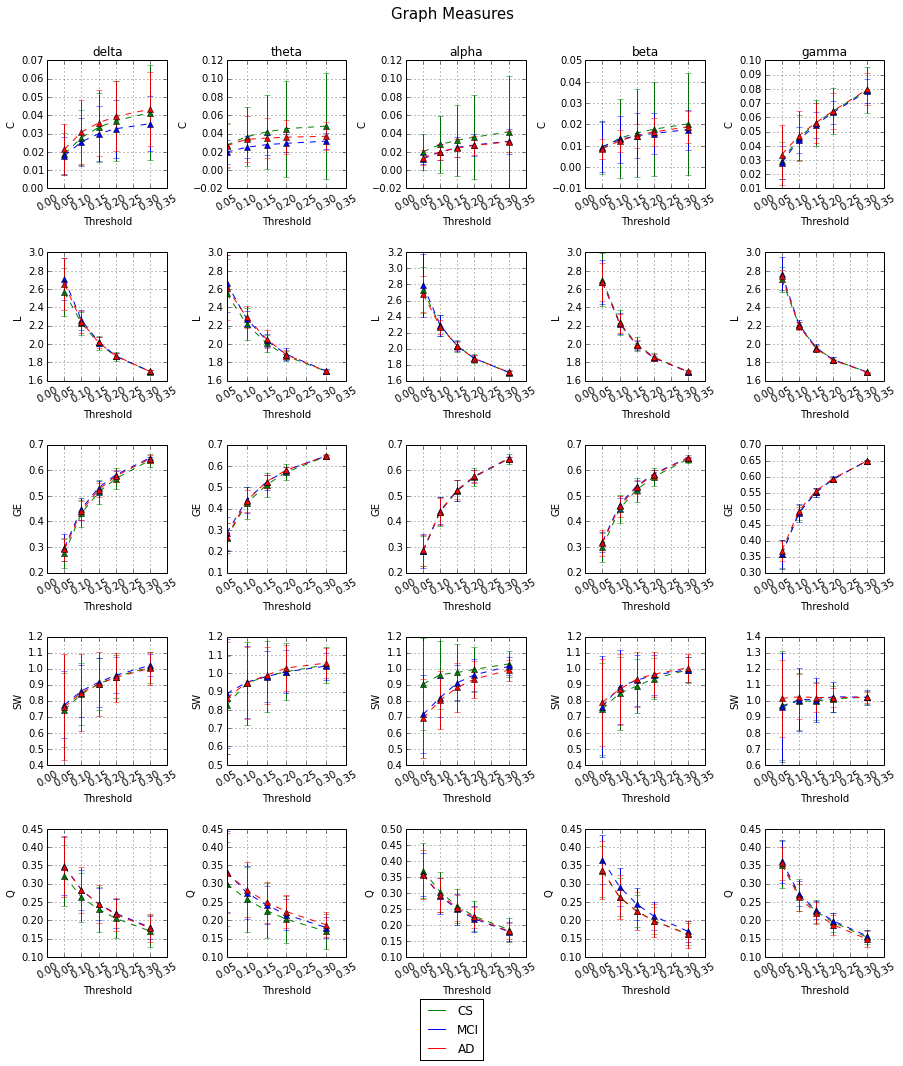

In [30]:
###########################################################
### ! The MOST complicated plot I ever made. ! ############
###########################################################

Caverages = np.empty([10, 10])
Laverages = np.empty([])

myFig, axes = plt.subplots(nrows=5, ncols=5)
my_axes = [MyAxis(ax,myFig) for ax in axes.ravel()]

#myFig.tight_layout()
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.93      # the top of the subplots of the figure
wspace = 0.5   # the amount of width reserved for blank space between subplots
hspace = 0.5   # the amount of height reserved for white space between subplots

myFig.subplots_adjust(left, bottom, right, top, wspace, hspace)

for thisAx in my_axes:
    # delete all axes
    thisAx.del_ax()
    #my_axes[6].del_ax()

myFig.set_size_inches(15,15)

myFig.suptitle('Graph Measures', fontsize=15)


### Here we generate dictionaries of graph measures, where each graph measure points to a
### dict of bands of interest (alfa, beta..); each band of interest points to a dictionary of classes (MCI, AD..);
### each class then points to a dictionary of thresholds, where each threshold points to the value of 
### the graph measure
### 
### Summary: graph measure --> band --> class --> threshold --> graph measure value
### (it's ugly, but it gets the job done...)

measureToBand = dict()

plotBandNames = True # plot band names only on first row of subplots

# for each graph measure
for currentMeasure, measureOrder in sorted(graphMeasures.iteritems(), key=operator.itemgetter(1)):
          
    bandToClass = dict()    
    
    # for each frequency band of interest
    for bandOrderIdx in plot_order.keys():
        bandName = plot_order[bandOrderIdx]
       
           
        bandPlot = myFig.add_subplot(5,5,len(graphMeasures)*(graphMeasures[currentMeasure]-1)+bandOrderIdx)
        bandPlot.hold(True)
        
        if (plotBandNames):
            bandPlot.set_title(bandName)
        #leg = []
        #legp = []
        bandPlot.set_xlabel('Threshold')
        bandPlot.set_ylabel(currentMeasure)    
        
        classToThreshold = dict()
                       
        for currentClass in sorted(classLabels.keys()):
            means = np.empty([len(thresholdVec)])
            stdDevs = np.empty([len(thresholdVec)])                      
            
            thresholdToMeasureValue = dict()
            
            for threshold in np.nditer(thresholdVec):
        
                data_file_path = DATASETS_FOLDER + str(threshold) + '/' +  nameOfDataFileMat

                # load dataset 
                data_dict = loadmat(data_file_path)
                data = data_dict['dataset']
                theThreshold = data_dict['threshold']
              
                n_samples = data.shape[0]
                features = data[:, :-1]
                targets = data[:, -1]

                  
                classIdxs = np.where(targets == currentClass)
               
                classFeatures = features[classIdxs]
                
                measureIndex = len(graphMeasures)*(FoQ_table_order[bandName]-1) + (graphMeasures[currentMeasure]-1)
                
                # compute average and mean of all subjects in the current class
                meanClass = (classFeatures[:, measureIndex]).mean()  
                stdClass = (classFeatures[:, measureIndex]).std()
                
                # gets first index of threshold in thresholdVector
                rows, columns = np.where(thresholdVec==threshold)
                first_idx = sorted([r for r, c in zip(rows, columns) if c == 0])[0]
                
                # append mean and std in corresponding position
                means[first_idx] = meanClass
                stdDevs[first_idx] = stdClass
                
                thresholdToMeasureValue[threshold[()]] = meanClass
                
            classToThreshold[currentClass] = thresholdToMeasureValue
            #ap, = bandPlot.plot(thresholdVec, means)
            
            bandPlot.errorbar(thresholdVec, means, stdDevs, linestyle='--', marker='^')
           
            # rotate values on x axis
            plt.xticks(rotation=30)
            
            #legp.append(ap)
            #leg.append(classLabels[currentClass])
        
        # plot legend
        myFig.legend(legp, leg, loc='lower center')
        
           
        bandToClass[bandOrderIdx] = classToThreshold
    measureToBand[currentMeasure] = bandToClass
    
    plotBandNames = False  # finished plotting first row

In [31]:
myFig.savefig('GraphMeasuresWithErrorBar.pdf')

In [15]:
print leg

['CS', 'MCI', 'AD']


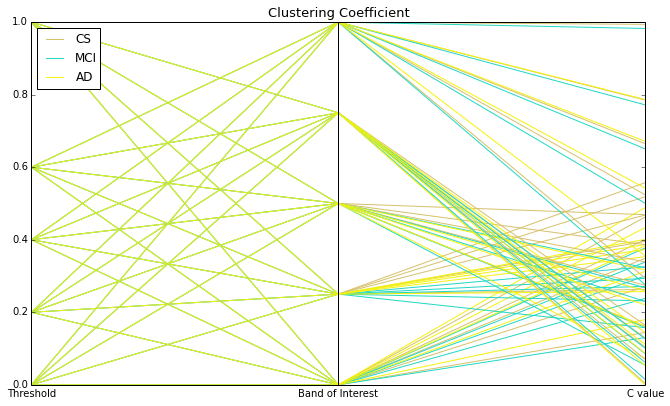

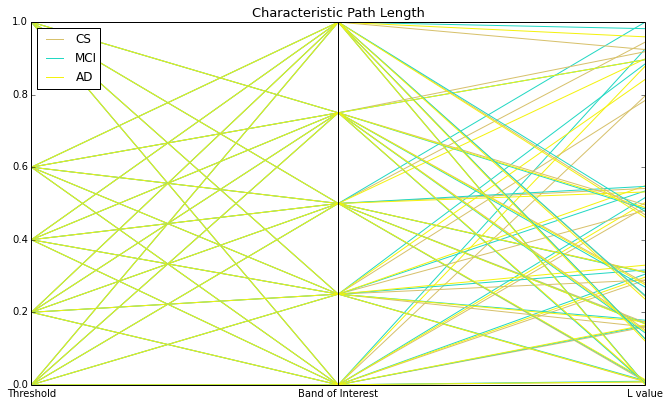

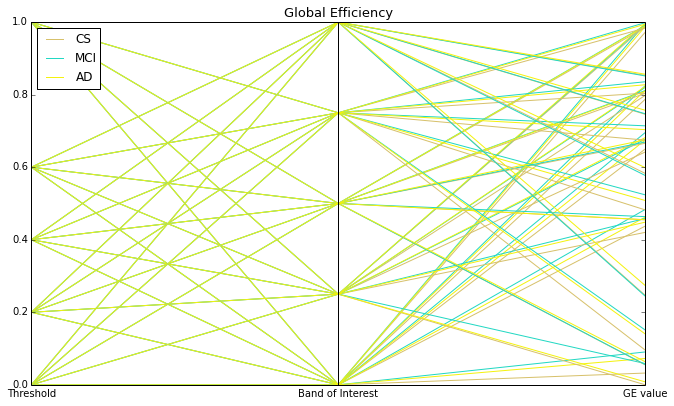

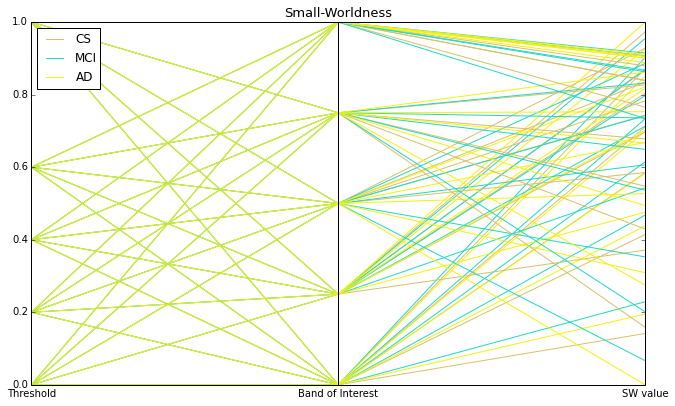

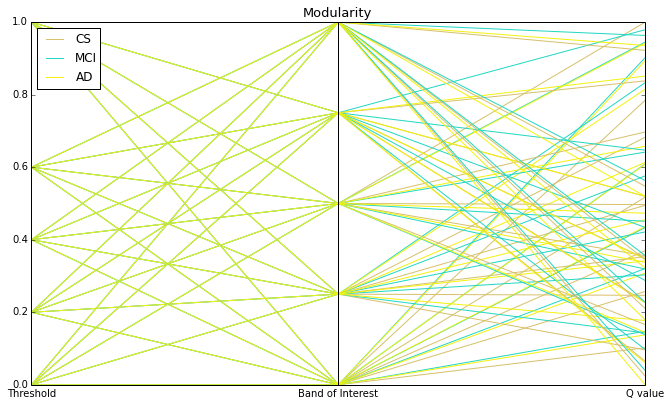

In [16]:
### Parallel coordinates

from pandas.tools.plotting import parallel_coordinates
from pandas import concat

# for each graph measure
for currentMeasure, measureOrder in sorted(graphMeasures.iteritems(), key=operator.itemgetter(1)):
    bandDic = measureToBand[currentMeasure]
    
    df = pd.DataFrame([
        [group, threshold, band, measureValue ] for band, groupDic in bandDic.items() \
                 for group, thresholdDic in groupDic.items()  \
                 for threshold, measureValue in thresholdDic.items()  \
    ])
   
    # rename columns
    df.rename(columns={1: 'Threshold', 2: 'Band of Interest', 3:currentMeasure + ' value'}, inplace=True)
    
    plt.figure(num=None, figsize=(11, 6.5))

    # normalise as values are very close to each other
    df_norm = (df - df.min()) / (df.max() - df.min())

    plt.rc('axes', color_cycle=[])
    axes = parallel_coordinates(df_norm, 0)
    axes.set_title(graphMeasuresLong[graphMeasures[currentMeasure]],fontsize=13)
    axes.set_color_cycle(['r', 'g', 'b', 'y'])
    legend = axes.legend(loc = 'upper left')
   
    legend.get_texts()[0].set_text('CS')
    legend.get_texts()[1].set_text('MCI')
    legend.get_texts()[2].set_text('AD')

### Boxplots and parallel coordinates plots for the features of each threshold

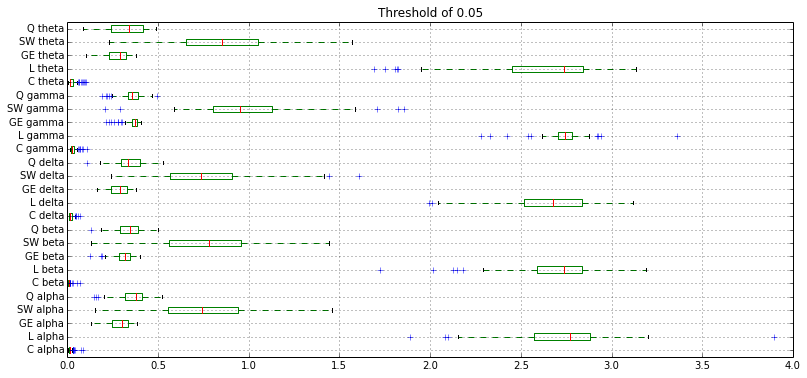

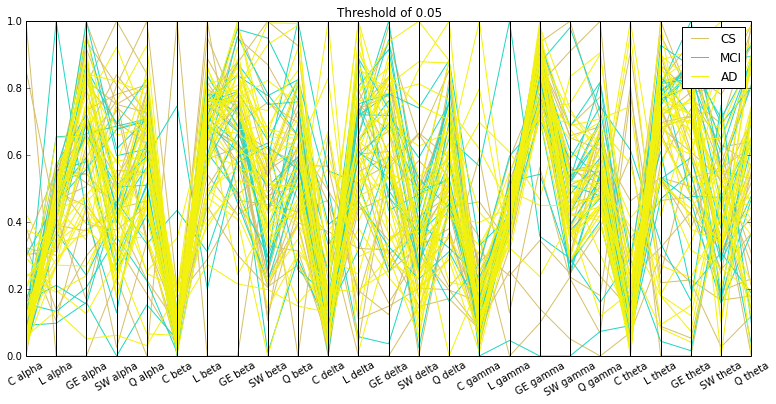

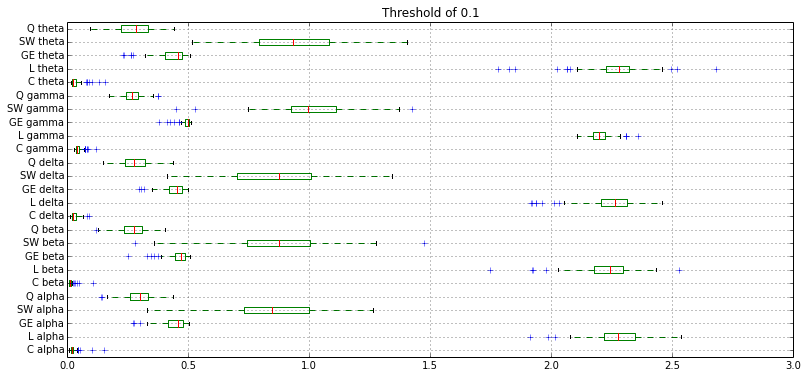

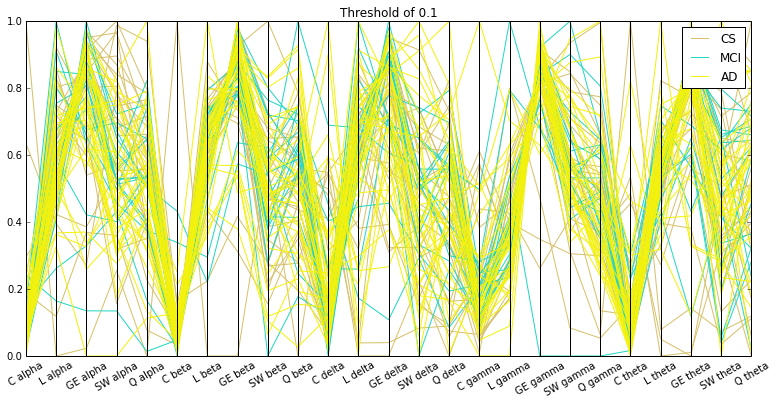

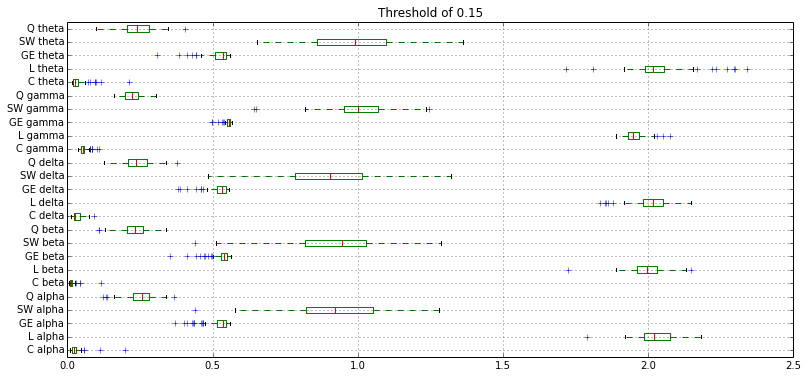

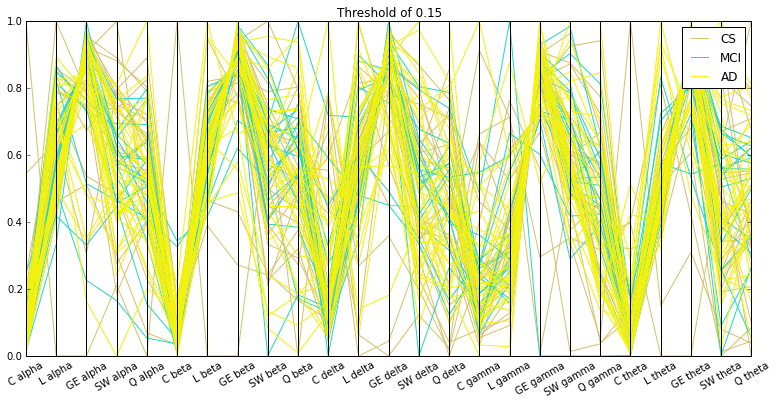

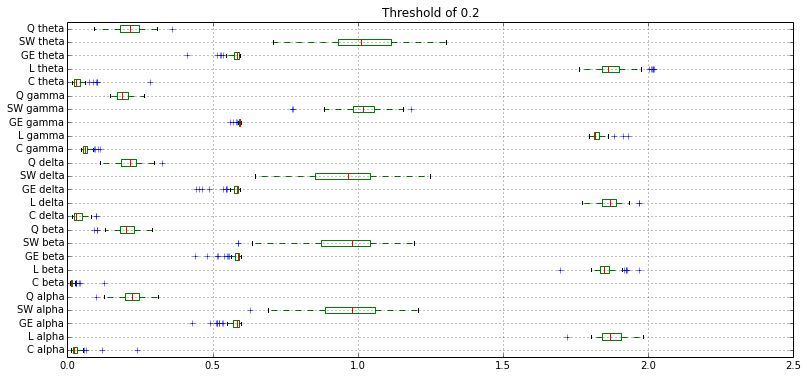

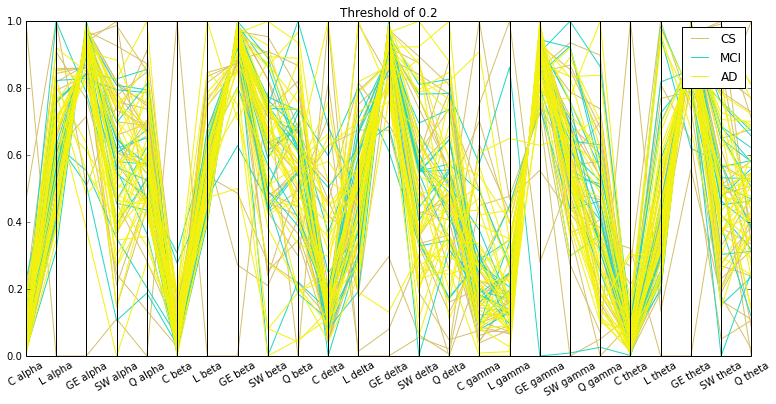

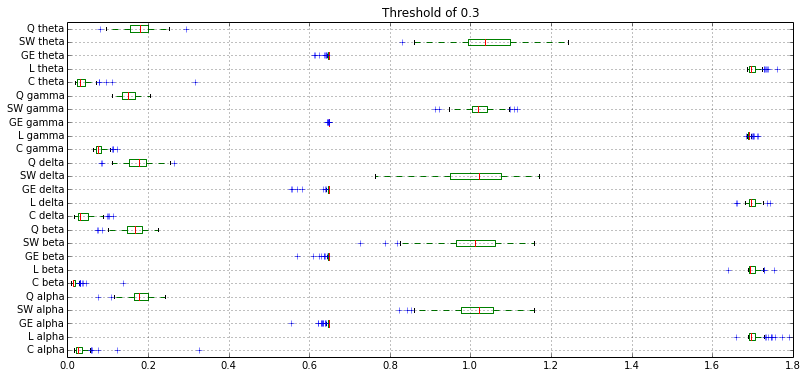

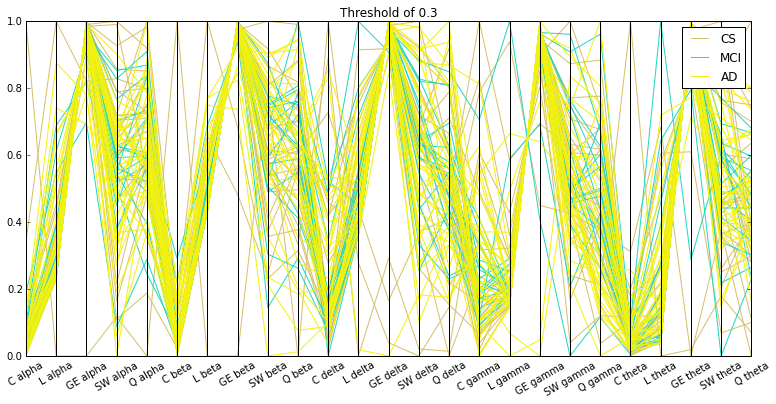

In [54]:
### Boxplots and Parallel coordinate plots for graph measures

idx = 1
for threshold in np.nditer(thresholdVec):
    
    data_file_path = DATASETS_FOLDER + str(threshold) + '/' +  nameOfDataFileCSV

    # load dataset 
    data = pd.DataFrame.from_csv(data_file_path, index_col=False)
   
    figure(num=None, figsize=(13,6))
    data.drop('Class', 1).boxplot(grid=True, vert=False)
    plt.title("Threshold of " + str(threshold))
    #figName = "boxplot"+"Thresh"+str(idx)+".pdf"
    #plt.savefig(figName)
    
    plt.figure(num=None, figsize=(13, 6))
    plt.title("Threshold of " + str(threshold))
    
    df_norm = (data - data.min()) / (data.max() - data.min())
    
    axes = parallel_coordinates(df_norm, 'Class')
    
    plt.xticks(rotation=30)
    axes.patch.set_alpha(0.5)
    legend = axes.legend(loc = 'upper right')
    legend.get_texts()[0].set_text('CS')
    legend.get_texts()[1].set_text('MCI')
    legend.get_texts()[2].set_text('AD')
    figName = "parallel"+"Thresh"+str(idx)+".pdf"
    plt.savefig(figName)
    idx = idx + 1

In [35]:
pwd

u'/home/dragos/DTC/MSc/SummerProject/report/images'

In [25]:
sorted(graphMeasures.iteritems(), key=operator.itemgetter(1))

[('C', 1), ('L', 2), ('GE', 3), ('SW', 4), ('Q', 5)]